# TFX

## TensorFlow Serving

In [6]:
import sys
assert sys.version_info.major == 3

In [7]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.9.2


In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [9]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


2022-07-20 15:01:10.978940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-20 15:01:10.979487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2022-07-20 15:01:11.300378: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   6/1875 [..............................] - ETA: 19s - loss: 2.2233 - sparse_categorical_accuracy: 0.1406  

2022-07-20 15:01:11.506990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.5186 - sparse_categorical_accuracy: 0.8191
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3752 - sparse_categorical_accuracy: 0.8665
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.8772
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8818
Epoch 5/5
 40/313 [==>...........................] - ETA: 1s - loss: 0.3365 - sparse_categorical_accuracy: 0.8844

2022-07-20 15:01:56.823212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.8779

Test accuracy: 0.8779000639915466


In [10]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:', export_path)

export_path = /var/folders/1p/mv6zp2c50kq37f3mrl211dth0000gp/T/1



INFO:tensorflow:Assets written to: /var/folders/1p/mv6zp2c50kq37f3mrl211dth0000gp/T/1/assets


INFO:tensorflow:Assets written to: /var/folders/1p/mv6zp2c50kq37f3mrl211dth0000gp/T/1/assets



Saved model: /var/folders/1p/mv6zp2c50kq37f3mrl211dth0000gp/T/1


In [17]:
## by python
# os.environ["MODEL_DIR"] = MODEL_DIR

## by shell
# nohup tensorflow_model_server \
#   --rest_api_port=8501 \
#   --model_name=fashion_model \
#   --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
# mv saved_model to 
# mv /var/folders/1p/mv6zp2c50kq37f3mrl211dth0000gp/T/1 /Users/cm.huang/Documents/workspace/projects/aurelius/tmp/fashion_model/1

# emacski/tensorflow-serving - arm64/v8
docker run -t --rm -p 8501:8501 \
    -v "/Users/cm.huang/Documents/workspace/projects/aurelius/tmp/fashion_model:/models/fashion_model" \
    -e MODEL_NAME=fashion_model \
    emacski/tensorflow-serving &

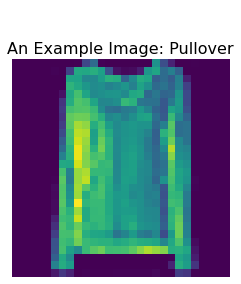

In [18]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [19]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


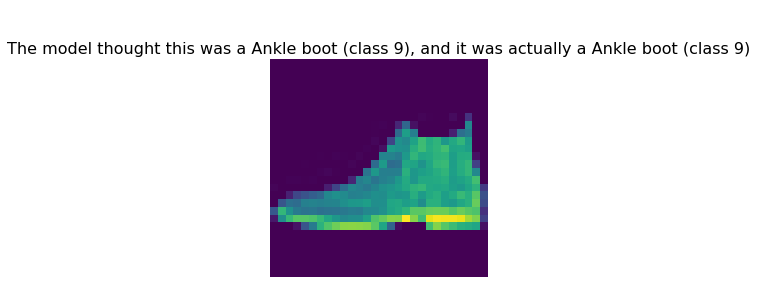

In [20]:
import requests, json
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

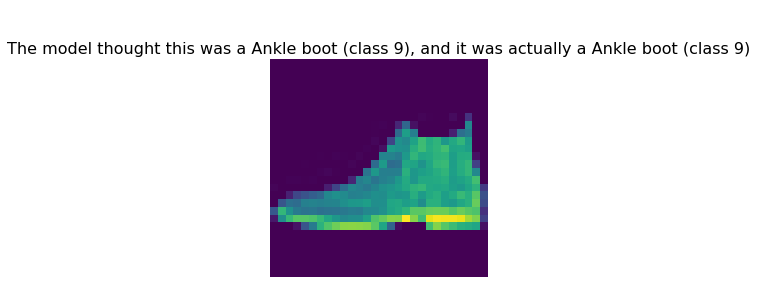

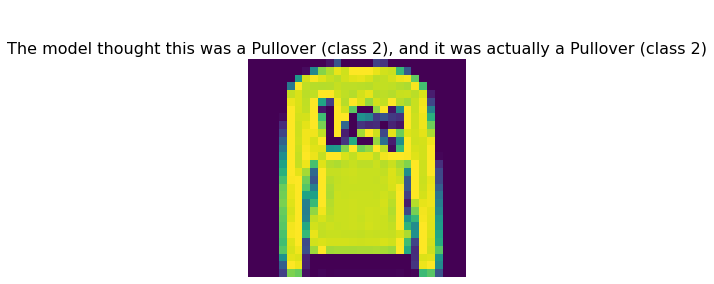

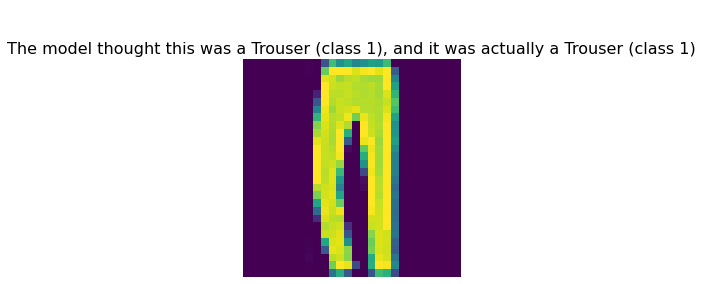

In [21]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))